# Fastazi replication package

This Colab notebook allows the reader to inspect the R code used to analyse and generate the data and plots available in the paper. It is split into three sections according to the research questions.

This notebook is part of the Fastazi replication package, which is in turn part of an AST 2022 submission. Please do not share while the paper is under review.

Before executing the code for any RQ, please run the prerequisite blocks.

## Prerequisites

In [92]:
#==================================================
# R environment
#==================================================
# Loads the R environment into the notebook.
%reload_ext rpy2.ipython

In [93]:
#==================================================
# Python libraries
#==================================================
import os 
import itertools as it

from bisect import bisect_left
from typing import List
import csv

import numpy as np
import pandas as pd
import scipy.stats as ss

from pandas import Categorical
from IPython.display import IFrame

In [94]:
#==================================================
# Download necessary files to the environment
#==================================================
# This downloads and uncompresses a ZIP file we prepared with needed files.
# These files are placed only on this Colab instance, nothing is downloaded
# to the computer.
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zOpI3q_JyZhIVjaVkfHO9Z1JDqgrmERs' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zOpI3q_JyZhIVjaVkfHO9Z1JDqgrmERs" -O fastazi-replication.zip && rm -rf /tmp/cookies.txt
!rm -r fastazi-replication
!unzip fastazi-replication.zip
!rm fastazi-replication.zip

Streaming output truncated to the last 5000 lines.
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/thread_pool.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/priority_class.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/semaphore.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/get_proc_address.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/shell.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/character_code_conversion.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/error_handling.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/init_once.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/handles.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/dll.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi/time.hpp  
  inflating: fastazi-replication/r-lib/BH/include/boost/winapi

In [95]:
%%R
#==================================================
# R Libraries
#==================================================
# Loads R libraries from the downloaded archive.
# This is much faster than installing them using the package manager.
.libPaths("/content/fastazi-replication/r-lib")
lib_loc <- "/content/fastazi-replication/r-lib"
library(readr, lib.loc = lib_loc)
library(ggplot2, lib.loc = lib_loc)
library(nortest, lib.loc = lib_loc)
library(agricolae, lib.loc = lib_loc) # kruskal with tukey groups
library(rcompanion, lib.loc = lib_loc)  # multiVDA
library(effsize, lib.loc = lib_loc) # VD.A
library(rstatix, lib.loc = lib_loc) # wilcox_test
library(gridExtra, lib.loc = lib_loc)
library(wesanderson, lib.loc = lib_loc)
library(dplyr)

In [96]:
%%R
draft_mode <- FALSE

subjects <- c("Chart", "Cli", "Closure", "Codec", "Collections", "Compress", "Gson", "Jsoup", "JxPath", "Lang", "Math", "Time")
max_faults <- c(26, 30, 168, 8, 4, 39, 18, 93, 4, 28, 100, 23)
names(max_faults) <- subjects

# Colors
my.cols = c(wes_palette("Zissou1", n = 5)[2:3], wes_palette("Darjeeling1", n = 5)[2], wes_palette("Zissou1", n = 5)[5])

subjects_dir <- "/content/fastazi-replication/subjects/"


## RQ1 (Effectiveness)

In [97]:
%%R
#==================================================
# Preparation
#==================================================
#LOAD RESULTS FILE
results_loc <- paste(subjects_dir, "all", "RQ1.csv", sep="/")

approaches <- c("Ekstazi+random","Fastazi-S","FAST-pw","Random")
v_factor_levels <- unique(approaches)

raw_results <- read_delim(results_loc, ",", escape_double = FALSE, trim_ws = TRUE)

raw_results <- subset(raw_results, Suite %in% approaches)

pdf_w <- 9
pdf_h <- 6

#reorder
raw_results$Suite <- factor(raw_results$Suite, levels=c("Ekstazi+random","FAST-pw","Fastazi-S","Random"),
                            labels=c("Ekstazi","FAST","Fastazi","Random"))

Rows: 2705 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Project, Suite
dbl (9): Version, Test count, APFD, APFDf, TTFF, pTTFF, Misses, Hit, HitCount

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### TTFF Boxplot

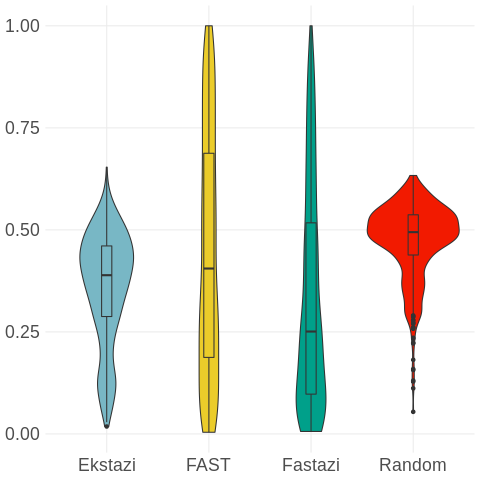

In [98]:
%%R
#==================================================
# Boxplots (TTFF)
#==================================================
pdf(sprintf("%s.pdf", 'TTFF'), width=pdf_w, height=pdf_h/2)
p <- ggplot(data=subset(raw_results, !is.na(pTTFF)), aes(Suite, pTTFF, fill=Suite)) +
  geom_violin(trim=TRUE) +
  geom_boxplot(width=0.1) +
  theme_minimal()  +
  theme(legend.position="none", axis.title = element_blank(), text = element_text(size = 22)) +
  theme(panel.grid.minor = element_blank()) +
  scale_fill_manual(values = my.cols)
dev.off()
show(p)

### NAPFD Boxplot

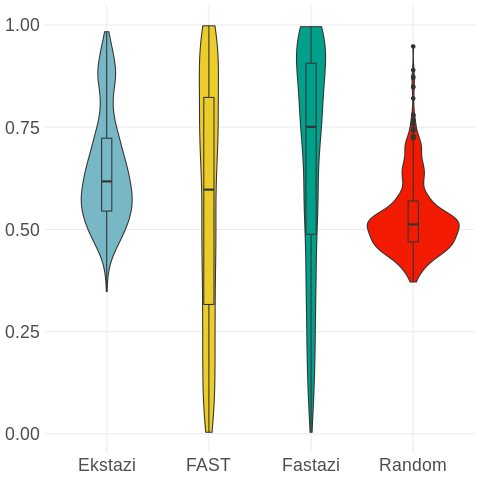

In [99]:
%%R
#==================================================
# Boxplots (APFD)
#==================================================
pdf(sprintf("%s.pdf", 'NAPFD'), width=pdf_w, height=pdf_h/2)
p <- ggplot(data=subset(raw_results, !is.na(APFDf)), aes(Suite, APFDf, fill=Suite)) +
  geom_violin(trim=TRUE) +
  geom_boxplot(width=0.1) +
  theme_minimal() +
  theme(legend.position="none", axis.title = element_blank(), text = element_text(size = 22)) +
  theme(panel.grid.minor = element_blank()) +
  scale_fill_manual(values = my.cols)
dev.off()
show(p)

In [100]:
%%R
#==================================================
# Normality Test
#==================================================
with(raw_results, ad.test(pTTFF))
with(raw_results, ad.test(APFDf))


	Anderson-Darling normality test

data:  APFDf
A = 13.767, p-value < 2.2e-16



In [101]:
%%R
#==================================================
# TTFF
#==================================================
# Kruskal-Wallis rank sum test
with(raw_results, tapply(pTTFF, Suite, median, na.rm=TRUE))
kruskal.test(pTTFF ~ Suite, data=raw_results)


	Kruskal-Wallis rank sum test

data:  pTTFF by Suite
Kruskal-Wallis chi-squared = 209.91, df = 3, p-value < 2.2e-16



In [102]:
%%R
#==================================================
# Pairwise comparisons using Wilcoxon’s test
#==================================================
wilcox_test(raw_results, pTTFF ~ Suite, p.adjust.method = "bonferroni")

# A tibble: 6 × 9
  .y.   group1  group2     n1    n2 statistic        p    p.adj p.adj.signif
* <chr> <chr>   <chr>   <int> <int>     <dbl>    <dbl>    <dbl> <chr>       
1 pTTFF Ekstazi FAST      541   541   129962  1   e- 3 9   e- 3 **          
2 pTTFF Ekstazi Fastazi   541   541   171949  6.27e- 7 3.76e- 6 ****        
3 pTTFF Ekstazi Random    541   541    67683  7.14e-53 4.28e-52 ****        
4 pTTFF FAST    Fastazi   541   541   178470. 4.07e-10 2.44e- 9 ****        
5 pTTFF FAST    Random    541   541   128834. 6.59e- 4 4   e- 3 **          
6 pTTFF Fastazi Random    541   541    85784  4.81e-32 2.89e-31 ****        


In [103]:
%%R
#==================================================
out <- kruskal(raw_results$pTTFF, raw_results$Suite)
out

$statistics
     Chisq Df p.chisq  t.value    MSD
  209.9073  3       0 1.961063 70.845

$parameters
            test p.ajusted            name.t ntr alpha
  Kruskal-Wallis      none raw_results$Suite   4  0.05

$means
        raw_results.pTTFF      rank        std   r         Min       Max
Ekstazi         0.3602183  954.1682 0.13558657 541 0.018191721 0.6536680
FAST            0.4419922 1139.8059 0.29465116 541 0.004081633 1.0000000
Fastazi         0.3323371  863.8401 0.26731389 541 0.006024096 1.0000000
Random          0.4750573 1372.1858 0.09133337 541 0.054125413 0.6333333
               Q25       Q50       Q75
Ekstazi 0.28761468 0.3888889 0.4607143
FAST    0.18750000 0.4052980 0.6877470
Fastazi 0.09756098 0.2509653 0.5172414
Random  0.43835294 0.4943741 0.5369048

$comparison
NULL

$groups
        raw_results$pTTFF groups
Random          1372.1858      a
FAST            1139.8059      b
Ekstazi          954.1682      c
Fastazi          863.8401      d

attr(,"class")
[1] "group"


In [104]:
%%R
#==================================================
# NAPFD
#==================================================
#Kruskal-Wallis rank sum test
with(raw_results, tapply(APFDf, Suite, median, na.rm=TRUE))
kruskal.test(APFDf ~ Suite, data=raw_results)


	Kruskal-Wallis rank sum test

data:  APFDf by Suite
Kruskal-Wallis chi-squared = 210.67, df = 3, p-value < 2.2e-16



In [105]:
%%R
#==================================================
# Pairwise comparisons using Wilcoxon’s test")
#==================================================
wilcox_test(raw_results, APFDf ~ Suite, p.adjust.method = "bonferroni")

# A tibble: 6 × 9
  .y.   group1  group2     n1    n2 statistic        p    p.adj p.adj.signif
* <chr> <chr>   <chr>   <int> <int>     <dbl>    <dbl>    <dbl> <chr>       
1 APFDf Ekstazi FAST      541   541   162747  1   e- 3 8   e- 3 **          
2 APFDf Ekstazi Fastazi   541   541   120648  5.76e- 7 3.46e- 6 ****        
3 APFDf Ekstazi Random    541   541   225062. 5.91e-53 3.55e-52 ****        
4 APFDf FAST    Fastazi   541   541   114123  3.64e-10 2.18e- 9 ****        
5 APFDf FAST    Random    541   541   163830  6.67e- 4 4   e- 3 **          
6 APFDf Fastazi Random    541   541   207074  3.19e-32 1.91e-31 ****        


In [106]:
%%R
#==================================================

out <- kruskal(raw_results$APFDf, raw_results$Suite)
out

$statistics
     Chisq Df p.chisq  t.value      MSD
  210.6746  3       0 1.961063 70.83109

$parameters
            test p.ajusted            name.t ntr alpha
  Kruskal-Wallis      none raw_results$Suite   4  0.05

$means
        raw_results.APFDf      rank        std   r         Min       Max
Ekstazi         0.6455694 1210.8457 0.13532232 541 0.348262548 0.9834423
FAST            0.5637955 1024.9501 0.29441471 541 0.004132231 0.9979592
Fastazi         0.6734506 1301.8041 0.26712185 541 0.004132231 0.9958678
Random          0.5307303  792.4002 0.09097119 541 0.371468927 0.9475248
              Q25       Q50       Q75
Ekstazi 0.5450450 0.6175439 0.7231214
FAST    0.3166667 0.5974576 0.8229167
Fastazi 0.4883041 0.7509653 0.9063604
Random  0.4697062 0.5123552 0.5696970

$comparison
NULL

$groups
        raw_results$APFDf groups
Fastazi         1301.8041      a
Ekstazi         1210.8457      b
FAST            1024.9501      c
Random           792.4002      d

attr(,"class")
[1] "group"


### Effect size analysis

In [107]:
def VD_A(treatment: List[float], control: List[float]):
    m = len(treatment)
    n = len(control)

    if m != n:
        raise ValueError("Data d and f must have the same length")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    A = (2 * r1 - m * (m + 1)) / (2 * n * m) 

    levels = [0.12, 0.28, 0.42]  # (small, >= 0.56; medium, >= 0.64; large, >= 0.71)
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude

In [108]:
apfdf_dict = {}
pttff_dict = {}

metrics = ['apfdf', 'pttff']
subjects = ["Chart", "Cli", "Closure", "Codec", "Collections", "Compress", "Gson", "Jsoup", "JxPath", "Lang", "Math", "Time"]
suites = ["Ekstazi+random", "FAST-pw", "Fastazi-S", "Fastazi-P", "Random"]
dicts = [apfdf_dict, pttff_dict]


for dict_ in dicts:
    for subject in subjects:
        dict_[subject] = {}
        for suite in suites:
            dict_[subject][suite] = []


with open(os.path.join('fastazi-replication','subjects','all','RQ1.csv')) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)  # skip the headers

    for row in reader:
        subject, version, suite, tccount, apfd, apfdf, ttff, pttff, misses, hit, hitcount = row
        apfdf = float(apfdf)
        pttff = 1 - float(pttff)

        apfdf_dict[subject][suite].append(apfdf)
        pttff_dict[subject][suite].append(pttff)

for metric in metrics:
    print('{}\n{}\n{}'.format('='*80, metric, '='*80))
    if metric == 'apfdf': dict_ = apfdf_dict
    elif metric == 'pttff': dict_ = pttff_dict
        
    for subject in subjects:
        print('{}\n{}\n{}'.format('-'*80, subject, '-'*80))
        control_fast = dict_[subject]["FAST-pw"]
        control_ekstazi = dict_[subject]["Ekstazi+random"]
        control_random = dict_[subject]["Random"]
        treatment_s = dict_[subject]["Fastazi-S"]

        print("EKSTAZI vs FAST: ", VD_A(control_ekstazi, control_fast))
        print("FASTAZI-S vs RANDOM: ", VD_A(treatment_s, control_random))
        print("FASTAZI-S vs FAST: ", VD_A(treatment_s, control_fast))
        print("FASTAZI-S vs EKSTAZI: ", VD_A(treatment_s, control_ekstazi))

apfdf
--------------------------------------------------------------------------------
Chart
--------------------------------------------------------------------------------
EKSTAZI vs FAST:  (0.7795857988165681, 'large')
FASTAZI-S vs RANDOM:  (0.8520710059171598, 'large')
FASTAZI-S vs FAST:  (0.790680473372781, 'large')
FASTAZI-S vs EKSTAZI:  (0.5724852071005917, 'small')
--------------------------------------------------------------------------------
Cli
--------------------------------------------------------------------------------
EKSTAZI vs FAST:  (0.22555555555555556, 'large')
FASTAZI-S vs RANDOM:  (0.8511111111111112, 'large')
FASTAZI-S vs FAST:  (0.56, 'small')
FASTAZI-S vs EKSTAZI:  (0.8133333333333334, 'large')
--------------------------------------------------------------------------------
Closure
--------------------------------------------------------------------------------
EKSTAZI vs FAST:  (0.5097434807256236, 'negligible')
FASTAZI-S vs RANDOM:  (0.6271967120181405, 's

## RQ2 (Effectiveness under a limited budget)

In [109]:
%%R
#==================================================
# Preparation
#==================================================
pdf_w <- 11.7
pdf_h <- 4.1

results_loc <- paste(subjects_dir, "all", "RQ2a.csv", sep="/")
approaches <- c("Ekstazi+random","Fastazi-S","FAST-pw","Random")

budgets <- c("25%","50%","75%","100%")

#LOAD RESULTS FILE
raw_results <- read_delim(results_loc, ",", escape_double = FALSE, trim_ws = TRUE)

# Filtering
raw_results <- subset(raw_results, Suite %in% approaches)
raw_results <- subset(raw_results, Budget %in% budgets)

v_factor_levels <- unique(approaches)

raw_results$Budget_f = factor(raw_results$Budget, levels=c("25%","50%","75%","100%"))

#reorder
raw_results$Suite <- factor(raw_results$Suite, levels=c("Ekstazi+random","FAST-pw","Fastazi-S","Random"),
                            labels=c("Ekstazi","FAST","Fastazi","Random"))

Rows: 32460 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Budget (all)

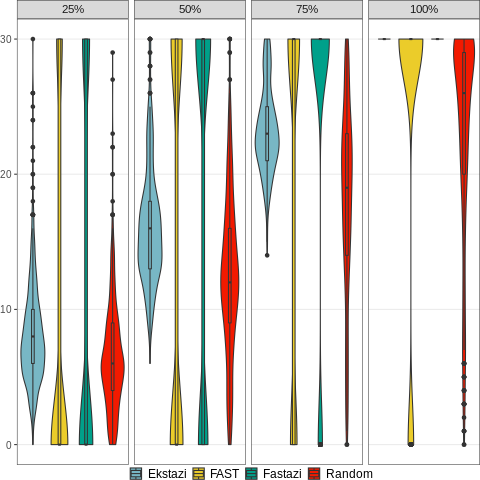

In [110]:
%%R
#==================================================
# BOX PLOT - Per budget - all subjects together
#==================================================
pdf("RQ2a.pdf", width=pdf_w, height=pdf_h/1.5)
p <- ggplot(raw_results, aes(x=Suite, y=HitCount, fill=Suite)) + 
  geom_violin(trim=TRUE) +
  geom_boxplot(width=0.1) +
  facet_wrap(~Budget_f, ncol = 4) + #facet_wrap(~Budget, ncol = 5) +
  theme_bw() +
  theme(axis.title = element_blank(), axis.text.x = element_blank(), axis.ticks.x=element_blank(),
        legend.title = element_blank(), legend.position = 'bottom', legend.text = element_text(size = 12), legend.key.size = unit(0.45, 'cm')) +
  theme(panel.grid.minor = element_blank(), panel.grid.major.x = element_blank(),
        strip.text.x = element_text(size = 11.5),
        axis.text.y = element_text(size=10)) +
  theme(plot.margin=grid::unit(c(0,0,0,0), "mm")) +
  theme(legend.margin=margin(t=-0.4, r=0, b=0, l=0, unit="cm")) +
  scale_fill_manual(values = my.cols, labels=c("Ekstazi","FAST","Fastazi","Random"))
dev.off()
show(p)

In [111]:
%%R
get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

In [112]:
%%R
#==================================================
# Preparation
#==================================================
input_file = "budget_selected_avg.csv"
budgets <- c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0)
my.breaks = seq(0.1, 1, 0.1)

approaches <- c("Ekstazi+random","Fastazi-S","FAST-pw","Random")
v_factor_levels <- unique(approaches)
pdf_w <- 8.49
pdf_h <- 6.4

#==================================================
subjects = c("Chart", "Cli", "Closure", "Codec", "Collections", "Compress", "Gson", "Jsoup", "JxPath", "Lang", "Math", "Time")
plots <- list()

### Budget (per subject)

In [113]:
%%R
pdf("RQ2b.pdf", width=pdf_w, height=pdf_h, onefile=FALSE)

for(subject in subjects) {
  max_faults_ = as.numeric(max_faults[subject])

  results_loc <- paste(subjects_dir, subject, input_file, sep="/")
  
  #LOAD RESULTS FILE
  raw_results <- read_delim(results_loc, ",", escape_double = FALSE, trim_ws = TRUE)
  
  # Convert 50% to 0.5...
  raw_results$Budget <- as.numeric(gsub("%", "", paste(raw_results$Budget)))/100
  
  # Filtering
  raw_results <- subset(raw_results, Suite %in% approaches)
  raw_results <- subset(raw_results, Budget %in% budgets)
  
  #reorder
  raw_results$Suite <- factor(raw_results$Suite, levels=c("Ekstazi+random","FAST-pw","Fastazi-S","Random"),
                              labels=c("Ekstazi","FAST","Fastazi","Random"))
  
  # group per budget (individual subjects)
  grouped = raw_results %>% 
    group_by(Project, Budget, Suite) %>% 
    summarise(RelBudget = round(mean(RelBudget), digits = 2), Hit = sum(Hit))
  
  sec = filter(grouped, Suite == "Ekstazi")$RelBudget
  
  #===
  p <- ggplot(grouped, aes(fill=Suite, y=Hit, x=Budget)) + 
    geom_bar(position="dodge", stat="identity") +
    scale_x_continuous(breaks = budgets, labels = NULL, sec.axis=sec_axis(~ . + 0, breaks = budgets, labels = sec)) +
    scale_y_continuous(breaks = c(0, round(max_faults_*0.25, digits = 0), round(max_faults_*0.5, digits = 0), round(max_faults_*0.75, digits = 0), round(max_faults_*1.0, digits = 0))) +
    expand_limits(y=c(0, max_faults_)) +
    theme_minimal()  +
    theme(axis.title.x = element_blank(), axis.text.x.top = element_text(angle = 45)) +
    theme(text = element_text(size = 10)) +
    theme(axis.title.y.left = element_text(size=11)) + 
    theme(legend.position = "bottom") +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm")) +
    theme(panel.grid.minor = element_blank()) +
    labs(y=subject) + #, x ="Dose (mg)", y = "Teeth length")
    theme(legend.title = element_blank(), legend.text = element_text(size = 9), legend.key.size = unit(0.25, 'cm')) +
    scale_fill_manual(values = my.cols, labels=c("Ekstazi","Fast","Fastazi","Random"))
  if(subject %in% c('Lang','Math','Time')){
    p <- p + scale_x_continuous(breaks = budgets, sec.axis=sec_axis(~ . + 0, breaks = budgets, labels = sec)) +
      theme(axis.line.x.bottom = element_line(size=0.5), axis.text.x.bottom = element_text(face="bold",size=8, angle = 0))
  }
  if(subject %in% c('Closure','Compress','JxPath','Time')){
    p <- p + scale_y_continuous(breaks = c(0, round(max_faults_*0.25, digits = 0), round(max_faults_*0.5, digits = 0), round(max_faults_*0.75, digits = 0), round(max_faults_*1.0, digits = 0)), sec.axis = dup_axis(labels = c(0, ".25", ".5", ".75", 1))) +
      theme(axis.line.y.right = element_line(size=0.5), axis.text.y.right = element_text(face = "bold", size=8), axis.title.y.right = element_blank())
  }
  #===
  legend <- get_legend(p)
  #---
  p <- p + theme(legend.position = 'none')
  #===
  
  # Grouped
  plots[[paste0(subject)]] <- p
  
  if(subject == 'Time'){
    plots[['legend']] <- legend
  }
}

print(length(plots))

grid.arrange(grobs=plots, ncol=3, nrow=5, layout_matrix = rbind(c(1,2,3), c(4,5,6), c(7,8,9), c(10,11,12), c(13,13,13)),
             widths = c(2.83, 2.83, 2.83), heights = c(1.8, 1.8, 1.8, 1.8, 0.2))
dev.off()

Rows: 1560 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.
Rows: 1800 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.
Rows: 10080 Column

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



Rows: 480 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.
Rows: 240 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.
Rows: 2340 Columns: 

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



Rows: 1080 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.
Rows: 5580 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.
Rows: 240 Columns:

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



Rows: 1680 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.


R[write to console]: Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



Rows: 6000 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.


R[write to console]: Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



Rows: 1380 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Project, Budget, Suite
dbl (10): Version, RelBudget, Test count, APFD, APFDf, TTFF, pTTFF, Misses, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Project', 'Budget'. You can override using the `.groups` argument.


R[write to console]: Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



[1] 13
png 
  2 


## RQ3 (Efficiency comparison)

In [114]:
%%R
#==================================================
# Preparation
#==================================================

#LOAD RESULTS FILE
results_loc <- paste(subjects_dir, "all", "RQ3.csv", sep="/")
raw_results <- read.table(results_loc, header=TRUE, sep=",")

In [115]:
%%R
#==================================================
# Normality Test (Time)
#==================================================
shapiro.test(raw_results$Time)


	Shapiro-Wilk normality test

data:  raw_results$Time
W = 0.56952, p-value = 4.265e-09



In [116]:
%%R
#==================================================
# Kruskal-Wallis Rank Sum Test (Time)
#==================================================
#Kruskal-Wallis rank sum test
#with(raw_results, tapply(TTFF, Suite, median, na.rm=TRUE))
kruskal.test(Time ~ Group, data=raw_results)


	Kruskal-Wallis rank sum test

data:  Time by Group
Kruskal-Wallis chi-squared = 20.012, df = 2, p-value = 4.512e-05



In [117]:
%%R
#Kruskal-Wallis rank sum test (MULTIPLE COMPARISON)
# kruskalmc(Time ~ Group, data=raw_results)

out <- kruskal(raw_results$Time, raw_results$Group)
out

$statistics
     Chisq Df      p.chisq  t.value      MSD
  20.01223  2 4.512313e-05 2.034515 5.896231

$parameters
            test p.ajusted            name.t ntr alpha
  Kruskal-Wallis      none raw_results$Group   3  0.05

$means
        raw_results.Time      rank       std  r Min  Max    Q25   Q50    Q75
Ekstazi        658.00000 23.416667 900.97483 12 137 3224 225.75 279.5 561.75
Fast            49.83333  7.416667  75.75179 12   3  265   9.00  20.0  48.50
Fastazi        688.16667 24.666667 914.73293 12 147 3259 228.50 300.0 613.00

$comparison
NULL

$groups
        raw_results$Time groups
Fastazi        24.666667      a
Ekstazi        23.416667      a
Fast            7.416667      b

attr(,"class")
[1] "group"


In [118]:
%%R
#==================================================
# Pairwise comparisons using Wilcoxon’s test
#==================================================
wilcox_test(raw_results, Time ~ Group, p.adjust.method = "bonferroni")

# A tibble: 3 × 9
  .y.   group1  group2     n1    n2 statistic        p    p.adj p.adj.signif
* <chr> <chr>   <chr>   <int> <int>     <dbl>    <dbl>    <dbl> <chr>       
1 Time  Ekstazi Fast       12    12       138 0.000154 0.000462 ***         
2 Time  Ekstazi Fastazi    12    12        65 0.713    1        ns          
3 Time  Fast    Fastazi    12    12         5 0.000122 0.000366 ***         


In [119]:
%%R
#==================================================
# Pairwise Vargha and Delaney's A and Cliff's delta
#==================================================
multiVDA(Time ~ Group, data=raw_results)

$pairs
         Comparison    VDA     CD      rg  VDA.m  CD.m   rg.m
1    Ekstazi - Fast 0.9580  0.916  0.9170 0.9580 0.916 0.9170
2 Ekstazi - Fastazi 0.4510 -0.098 -0.0972 0.5490 0.098 0.0972
3    Fast - Fastazi 0.0347 -0.931 -0.9310 0.9653 0.931 0.9310

$comparison
      Comparison 
"Fast - Fastazi" 

$statistic
   VDA 
0.0347 

$statistic.m
 VDA.m 
0.9653 

